--- In this example we look at aperture photometry.

In [1]:
import numpy as np
from astropy.io import fits

In [2]:
image_dir = 'data' # define image directory relative to this script

In [3]:
f = 'f125w' # filter

In [4]:
sci = fits.getdata(f'{image_dir}/{f}_sci.fits') # read science FITS file data into numpy array
wht = fits.getdata(f'{image_dir}/{f}_wht.fits') # read weight FITS file data into numpy array

In [5]:
mask = fits.getdata(f'{image_dir}/mask.fits') # read in the image mask
sci = np.ma.masked_array(sci, mask = mask) # apply the mask to our science image
wht = np.ma.masked_array(wht, mask = mask) # apply the mask to our weight image

--- cut out a portion of the image for analysis

In [6]:
x = 2500 # pixel x-centre of cutout, must be an integer
y = 2500 # pixel y-centre of cutout, must be an integer
r = 100 # width/2 of cutout, must be int

In [7]:
sci = sci[x-r:x+r, y-r:y+r] # cutout a portion of the science image
wht = wht[x-r:x+r, y-r:y+r] # cutout a portion of the weight image

--- define the noise in each pixel and make a significance map (signal/noise)

In [8]:
noise = 1./np.sqrt(wht) # conversion from weight to noise
sig = sci/noise # signifance map

--- now run segmentation on the image to detect sources.

In [9]:
from photutils import detect_sources

In [10]:
threshold = 2.5 # require each pixel have a significance of >2.5 (since we're using the significance image)
npixels = 5 # require at least 5 connected pixels

In [11]:
segm = detect_sources(sig, threshold, npixels=npixels) # make segmentation image

--- get various properties of the sources, crucially inclusing their centres

In [12]:
from photutils import SourceCatalog, CircularAperture

In [13]:
cat = SourceCatalog(sci, segm)

--- get a list of positions (x,y) of the sources

In [14]:
positions = []
for obj in cat:
    positions.append(np.transpose((obj.xcentroid, obj.ycentroid)))

--- make a CicrcularAperture object. This can be plotted but is mostly used for the aperture photometry.

In [15]:
r = 5. # radius of aperture in pixels
apertures = CircularAperture(positions, r)

--- let's make a plot of the sources and the apertures

In [16]:
import matplotlib.pyplot as plt

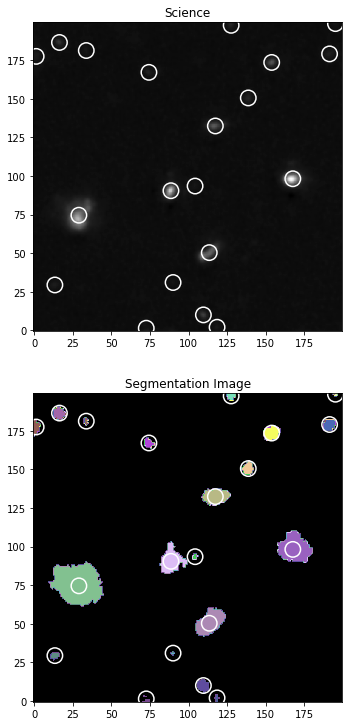

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(sci, origin='lower', cmap='Greys_r')
ax1.set_title('Science')
cmap = segm.make_cmap()
ax2.imshow(segm, origin='lower', cmap=cmap)
ax2.set_title('Segmentation Image')
for aperture in apertures:
    aperture.plot(axes=ax1, color='white', lw=1.5)
    aperture.plot(axes=ax2, color='white', lw=1.5)
plt.show()

--- now let's do some photometry

In [18]:
from photutils import aperture_photometry

In [19]:
phot_table = aperture_photometry(sci, apertures)
phot_table['aperture_sum'].info.format = '%.3f'  # for consistent table output
print(phot_table)

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1   72.6228960075881  1.410878628183665        0.156
  2  118.4863224799657 2.0495154963363813        0.137
  3 109.62743939853789 10.034575718885554        0.576
  4 13.456862649677296 29.414014725391073        0.215
  5  89.99568588379249 31.002968211487428        0.100
  6 113.42877106258788 50.358947483678705        2.036
  7  29.00284826120116  74.59168080669345        4.013
  8  88.60878709373883  90.44619219580102        3.030
  9 167.52983458532634  98.18594132652123        4.651
 10 104.23501637791564  93.46704197272467        0.173
 11 117.36675817217618 132.37865612646942        1.255
 12 138.69676344522188 150.52624427073053        0.396
 13   74.3525677920319 167.09040776118465        0.283
 14 153.85252765833738  173.5001018128976        0.936
 15 1.3405129824934536 177.43326890619403        0.246
 16 191.33